In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snsS

data = pd.read_csv('../../../datasets/AirPassengers.csv')
data.head()


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
data.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [5]:
data.isna().sum()

Month          0
#Passengers    0
dtype: int64

In [6]:
# Convert the date column (if it's not in datetime format)
data['Month'] = pd.to_datetime(data['Month'])

In [7]:
data.info() # we can see it convert from object to date-time 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [8]:
data.set_index('Month', inplace=True)

In [9]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


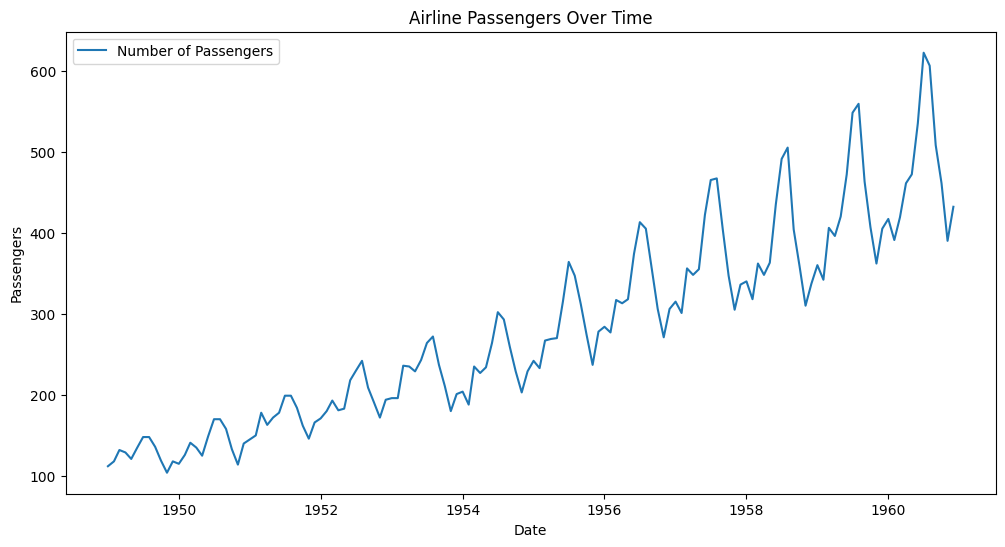

In [10]:
plt.figure(figsize=(12,6))
plt.plot(data['#Passengers'], label='Number of Passengers')
plt.title('Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## <span style="color:#2E86C1;">Time Series Decomposition</span>

Time series decomposition is a technique that breaks down a time series into three distinct components:

- **Trend**: The long-term movement in the data (upward or downward).
- **Seasonality**: Recurring patterns or cycles that repeat at regular intervals (e.g., monthly or yearly).
- **Residual (Noise)**: Random variation in the data that cannot be attributed to the trend or seasonality.

We use `seasonal_decompose` from the `statsmodels` library to perform an additive decomposition of the dataset.

**Additive Model**: Assumes the time series data is the sum of the trend, seasonality, and noise components.

> **Formula:**
> $$ y(t) = T(t) + S(t) + R(t) $$

A visual plot of the decomposition helps identify these individual components.

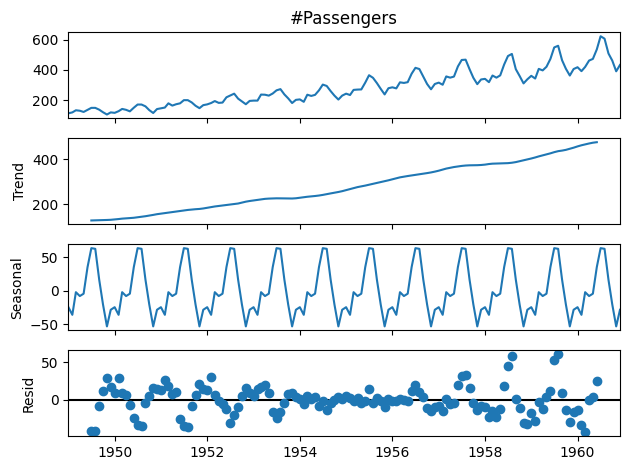

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(data['#Passengers'], model='additive')
decomposition.plot()
plt.show()



## <span style="color:#2E86C1;">2. Stationarity Check: Dickey-Fuller Test</span>

Before applying any forecasting model, we must ensure the time series is **stationary**. A stationary time series has:

- A constant mean and variance over time.
- No significant trend or seasonality remaining.

The **Augmented Dickey-Fuller (ADF) test** is used to check for stationarity.

- **Null Hypothesis (H₀)**: The time series is not stationary (contains a unit root).
- **Alternative Hypothesis (H₁)**: The time series is stationary.

> **Key Indicators**:
> - **ADF Statistic**: A more negative value indicates stronger evidence against the null hypothesis.
> - **p-value**: A value less than 0.05 typically leads us to reject the null hypothesis, indicating stationarity.

In [12]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result = adfuller(data['#Passengers'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641


## <span style="color:#2E86C1;">3. Differencing for Stationarity</span>

If the time series is not stationary, we apply **differencing** to remove trend and seasonality. This involves calculating the difference between consecutive observations.

- **First-order differencing** removes linear trends.
- **Second-order differencing** removes quadratic trends if needed.

In this notebook, we perform **first-order differencing** to stabilize the mean of the series:
$$ y'(t) = y(t) - y(t-1) $$

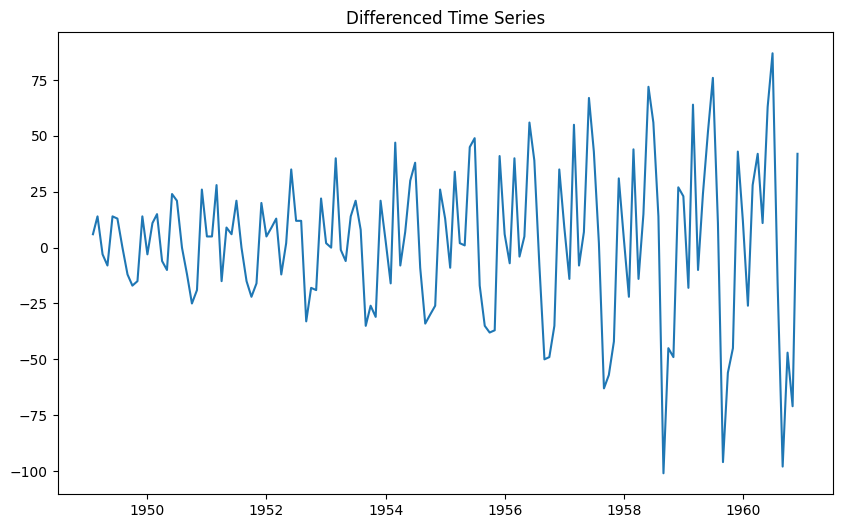

In [13]:
data_diff = data['#Passengers'].diff().dropna()

plt.figure(figsize=(10,6))
plt.plot(data_diff, label='Differenced Passengers Data')
plt.title('Differenced Time Series')
plt.show()


# ARIMA MODEL ( NON SEASONAL )

## <span style="color:#2E86C1;">Parameter Selection for SARIMA: ACF and PACF</span>

When building a SARIMA model, it's crucial to choose the right values for the parameters $p$, $d$, $q$, $P$, $D$, $Q$, and $s$. The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots are essential tools for this selection process.

### <span style="color:#28B463;">1. Differencing (d)</span>
- **Differencing** helps to make the time series stationary by removing trends. It involves subtracting the previous observation from the current one.
- The parameter $d$ indicates how many times you need to difference the data. You can use visual inspection and the Augmented Dickey-Fuller test to determine the appropriate level of differencing.

### <span style="color:#28B463;">2. Autocorrelation Function (ACF)</span>
- The **ACF** shows how the time series correlates with its past values (lags). This helps identify the **MA (Moving Average)** component of the model.
- In the ACF plot, look for significant spikes at the initial lags. If the spikes drop off quickly after a few lags, this suggests the value of $q$ (the order of the MA component).

### <span style="color:#28B463;">3. Partial Autocorrelation Function (PACF)</span>
- The **PACF** measures the correlation between the time series and its past values while controlling for shorter lags. This helps identify the **AR (AutoRegressive)** component of the model.
- In the PACF plot, if you see significant spikes at the first few lags followed by a drop, this indicates the value of $p$ (the order of the AR component).

<Figure size 1200x600 with 0 Axes>

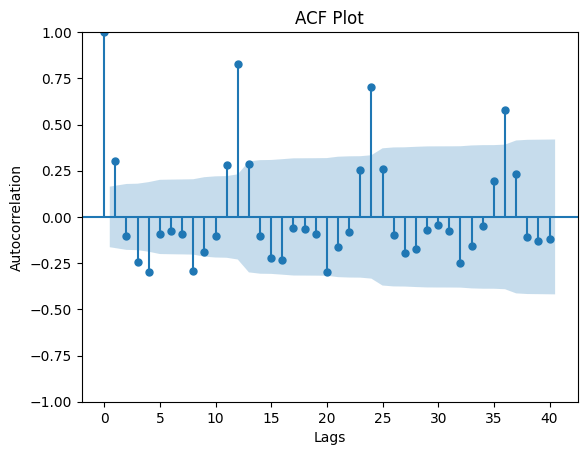

<Figure size 1200x600 with 0 Axes>

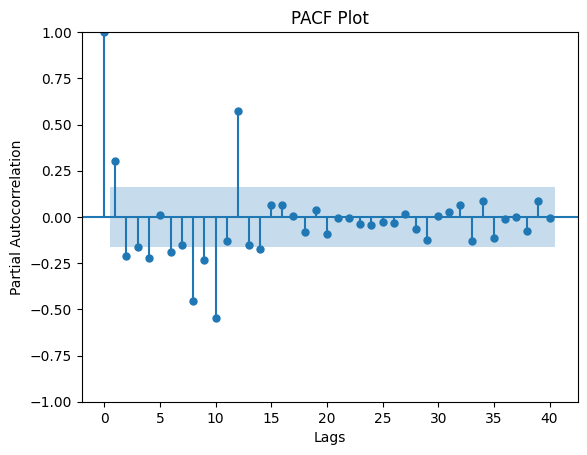

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the data to achieve stationarity
data_diff = data['#Passengers'].diff().dropna() # this will be the value for d = 1 

# ACF Plot
plt.figure(figsize=(12, 6))
plot_acf(data_diff, lags=40)
plt.title('ACF Plot')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# PACF Plot
plt.figure(figsize=(12, 6))
plot_pacf(data_diff, lags=40)
plt.title('PACF Plot')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

#### NOTE : always skip first bar line as its correlation with itself while considering value for p and q 
- In PACF Plot : first two bar are above threshold so value for (AR) p = 2
- In ACF Plot : first bar only is above threshold so value for (AR) q = 1
- differential(d) value is 1 here 

In [15]:
# Split data into training and testing sets
train = data[:'1959']
test = data['1959':]


## <span style="color:#2E86C1;">4. ARIMA Model</span>

The **ARIMA (AutoRegressive Integrated Moving Average)** model is a popular method for time series forecasting.

### Components of ARIMA:
- **AR (AutoRegressive)**: Models the relationship between an observation and some number of lagged observations. It is controlled by the parameter `p`.
- **I (Integrated)**: Involves differencing the data to make it stationary. The degree of differencing is controlled by the parameter `d`.
- **MA (Moving Average)**: Models the relationship between an observation and a lagged residual error from a moving average model, controlled by the parameter `q`.


In [41]:
from statsmodels.tsa.arima.model import ARIMA

# Build and train ARIMA model
model = ARIMA(train['#Passengers'], order=(2, 1, 1))  # ARIMA(p, d, q) i.e (AR , I , MA)
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

c:\Users\DELL\anaconda3\envs\NeuralNet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  132
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -619.131
Date:                Wed, 09 Oct 2024   AIC                           1246.262
Time:                        16:50:41   BIC                           1257.763
Sample:                    01-01-1949   HQIC                          1250.936
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0698      0.094     11.323      0.000       0.885       1.255
ar.L2         -0.4734      0.101     -4.670      0.000      -0.672      -0.275
ma.L1         -0.8402      0.085     -9.851      0.0

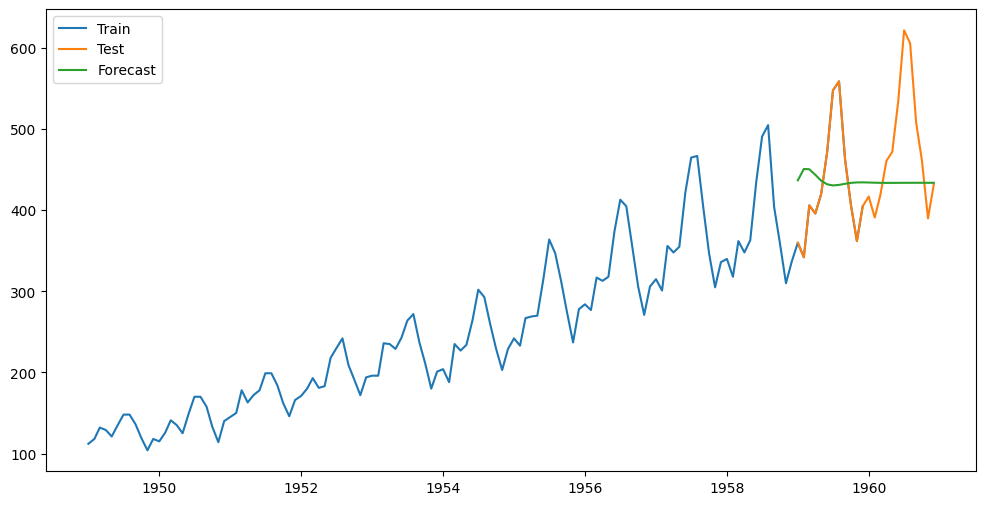

In [42]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(train['#Passengers'], label='Train')
plt.plot(test['#Passengers'], label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE
mse = mean_squared_error(test['#Passengers'], forecast)
mae = mean_absolute_error(test['#Passengers'], forecast)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 6238.519307727416
Mean Absolute Error: 61.98425205321766


# SARIMA MODEL ( SEASONAL )

## <span style="color:#2E86C1;">Seasonal ARIMA (SARIMA) Model</span>

The **SARIMA** (Seasonal AutoRegressive Integrated Moving Average) model extends the ARIMA model by adding components to handle **seasonality** in the time series. SARIMA is effective when the data exhibits clear repeating patterns over time, such as monthly or yearly trends.

### Components of SARIMA:
1. **Non-Seasonal ARIMA**:
   - **AR (AutoRegressive, p)**: The number of lag observations in the model.
   - **I (Integrated, d)**: The number of differencing required to make the series stationary.
   - **MA (Moving Average, q)**: The number of lagged forecast errors in the model.

2. **Seasonal ARIMA**:
   - **Seasonal AR (P)**: The seasonal autoregressive part.
   - **Seasonal I (D)**: The seasonal differencing.
   - **Seasonal MA (Q)**: The seasonal moving average.
   - **Seasonal Period (s)**: The length of the seasonal cycle (e.g., `s=12` for monthly data).

> **Formula**:
> $$ SARIMA(p, d, q) \times (P, D, Q, s) $$

- **p, d, q** refer to the non-seasonal ARIMA components.
- **P, D, Q** are the seasonal ARIMA components.
- **s** is the seasonal period (e.g., `s=12` for monthly seasonality).

### SARIMA in Practice:
SARIMA can capture both the short-term and long-term patterns in time series data, including any seasonal fluctuations. By incorporating these seasonal components, it often provides better forecasting performance for time series that exhibit **seasonal trends**.



<Figure size 1200x600 with 0 Axes>

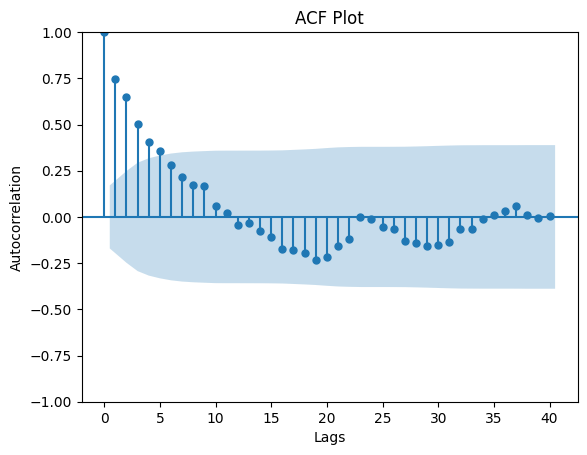

<Figure size 1200x600 with 0 Axes>

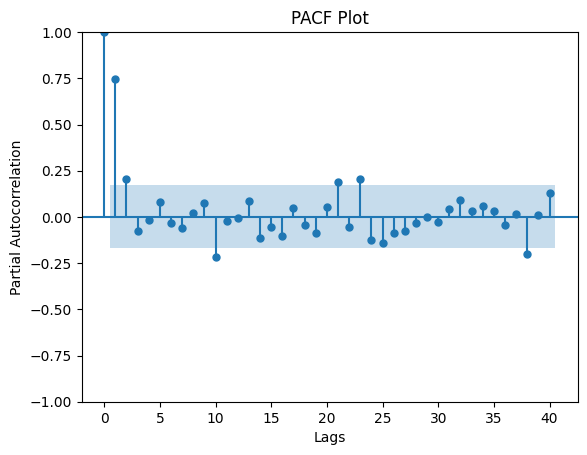

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the data to achieve stationarity
data_diff = data['#Passengers'].diff(12).dropna() # 12 diff for seasonal pattern ( i.e. D=1 )

# ACF Plot
plt.figure(figsize=(12, 6))
plot_acf(data_diff, lags=40)
plt.title('ACF Plot')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# PACF Plot
plt.figure(figsize=(12, 6))
plot_pacf(data_diff, lags=40)
plt.title('PACF Plot')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

#### NOTE : similarly for SARIMA always skip first bar line as its correlation with itself while considering value for P and Q 
- In PACF Plot : first two bar are above threshold so value for (AR) P = 2
- In ACF Plot : first five bars are above threshold so value for (AR) Q = 5
- differential(d) value is 1 here 

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

c:\Users\DELL\anaconda3\envs\NeuralNet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\anaconda3\envs\NeuralNet\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\DELL\anaconda3\envs\NeuralNet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:                                      #Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -209.762
Date:                                          Wed, 09 Oct 2024   AIC                            441.524
Time:                                                  16:56:09   BIC                            463.997
Sample:                                              01-01-1949   HQIC                           450.258
                                                   - 12-01-1959                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

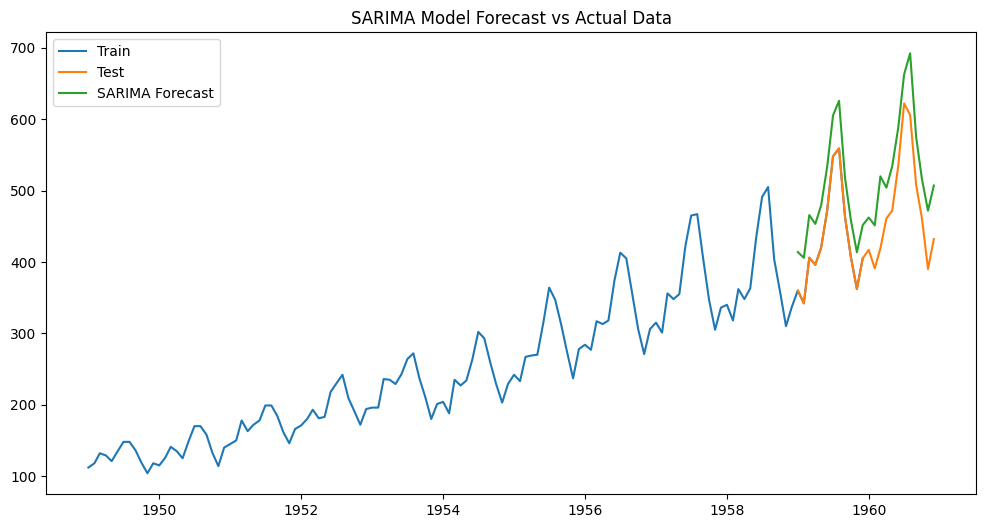

In [44]:
# Define SARIMA parameters: (p, d, q)(P, D, Q, s)
# s is the seasonal period (12 for monthly data)
sarima_model = SARIMAX(train['#Passengers'], 
                       order=(2, 1, 1),  # (p, d, q)
                       seasonal_order=(2, 1, 5, 12),  # (P, D, Q, s)
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit()

# Model summary
print(sarima_fit.summary())

# Forecasting
forecast_sarima = sarima_fit.forecast(steps=len(test))

# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(train['#Passengers'], label='Train')
plt.plot(test['#Passengers'], label='Test')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast')
plt.title('SARIMA Model Forecast vs Actual Data')
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE
mse = mean_squared_error(test['#Passengers'], forecast_sarima)
mae = mean_absolute_error(test['#Passengers'], forecast_sarima)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3859.5054590006293
Mean Absolute Error: 60.584151548869414
